compares the predicted results to the true results and calculates the scores  
creates the graph

In [1]:
# coding: utf-8

# In[2]:

import numpy as np
import pandas as pd
from scipy import stats as stats
import os
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
DESCRIPTORS=['INTENSITY/STRENGTH','VALENCE/PLEASANTNESS','BAKERY','SWEET','FRUIT','FISH','GARLIC','SPICES','COLD','SOUR','BURNT','ACID','WARM','MUSKY','SWEATY','AMMONIA/URINOUS','DECAYED','WOOD','GRASS','FLOWER','CHEMICAL']
SUBJECTS=range(1,50)


In [3]:
# function to calculate the scores

def read_data(fname):
    data=pd.read_table(fname,sep='\t',header=0,index_col='#oID')
    return data
    
def calculate_correlations_2(path,split):
    score_frame = []

    r={}
    s={}

    data1=read_data("LB_data/LBs"+str(split)+ "_2")
    #print(data1.head())
    data2=read_data(path)
    #print data1.shape,data2.shape
    data1 = data1.sort_index().sort_values('descriptor')
    data1.loc[data1.descriptor== ' CHEMICAL','descriptor'] = 'CHEMICAL'
    data1_mean = data1.reset_index().pivot_table(index = '#oID', columns = 'descriptor', values='value')
    data1_std = data1.reset_index().pivot_table(index = '#oID', columns = 'descriptor', values='sigma')
    data2 = data2.sort_index().sort_values('descriptor')
    data2_mean = data2.reset_index().pivot_table(index = '#oID', columns = 'descriptor', values='value')
    data2_std = data2.reset_index().pivot_table(index = '#oID', columns = 'descriptor', values='sigma')
    
       
    for desc in data1_std.columns:
        #print desc + ':' + str(stats.pearsonr(data1_mean[desc],data2_mean[desc])[0])
        if desc == 'INTENSITY/STRENGTH':
            score_frame.append([desc,stats.pearsonr(data1_mean[~data1_mean['INTENSITY/STRENGTH'].isnull()]['INTENSITY/STRENGTH'],
                                                    data2_mean[~data2_mean['INTENSITY/STRENGTH'].isnull()]['INTENSITY/STRENGTH'])[0]])
        else:
            score_frame.append([desc,stats.pearsonr(data1_mean[desc],data2_mean[desc])[0]])
           # others.append(stats.pearsonr(data1_mean[desc],data2_mean[desc])[0])
            

    return pd.DataFrame(score_frame)

In [4]:
# read the split prediction and calculate the scores
scores_linear = {}
scores_RF = {}
for k in range(10):
    for feature_number in [1,2,3,4,5,10,33,100,333,1000,3333,10000]:
        #print feature_number
        if feature_number == 1:
            scores_RF[k] = calculate_correlations_2('results_morgan_RF/' + str(k) + '/subchallenge2_' + str(feature_number) + '.txt',k)
            scores_RF[k].set_index(0,inplace=1)
            scores_RF[k].columns = [1]
            
            scores_linear[k] = calculate_correlations_2('results_morgan/' + str(k) + '/subchallenge2_' + str(feature_number) + '.txt',k)
            scores_linear[k].set_index(0,inplace=1)
            scores_linear[k].columns = [1]

            
        else:
            scores_RF[k][feature_number] = calculate_correlations_2('results_morgan_RF/' + str(k) +'/subchallenge2_' + str(feature_number) + '.txt',k)[1].values
            scores_linear[k][feature_number] = calculate_correlations_2('results_morgan/' + str(k) +'/subchallenge2_' + str(feature_number) + '.txt',k)[1].values

            
for k in range(10):
    scores_RF[k] = scores_RF[k].transpose()
    scores_RF[k] = scores_RF[k][DESCRIPTORS]
    scores_RF[k].head()
    
    scores_linear[k] = scores_linear[k].transpose()
    scores_linear[k] = scores_linear[k][DESCRIPTORS]
    scores_linear[k].head()



all_scores_RF = pd.concat([scores_RF[x] for x in range(len(scores_RF))], axis=1, keys=range(len(scores_RF)))
all_scores_linear = pd.concat([scores_linear[x] for x in range(len(scores_linear))], axis=1, keys=range(len(scores_linear)))


In [5]:
scores_RF[0].columns

Index([u'INTENSITY/STRENGTH', u'VALENCE/PLEASANTNESS', u'BAKERY', u'SWEET',
       u'FRUIT', u'FISH', u'GARLIC', u'SPICES', u'COLD', u'SOUR', u'BURNT',
       u'ACID', u'WARM', u'MUSKY', u'SWEATY', u'AMMONIA/URINOUS', u'DECAYED',
       u'WOOD', u'GRASS', u'FLOWER', u'CHEMICAL'],
      dtype='object', name=0)

In [6]:
#average the splits
def average_splits(all_):
    mean = all_.groupby(level=1, axis=1).mean()
    mean.columns = DESCRIPTORS
    mean.index.name = 'number of features'
    mean.index.name = 'number of features'
    

    std = all_.groupby(level=1, axis=1).std()/np.sqrt(10)
    std.columns = DESCRIPTORS
    std.index.name = 'number of features'
    std.index.name = 'number of features'
    
    return mean,std

In [7]:
linear_mean_noleak,linear_sem_noleak = average_splits(all_scores_linear)
RF_mean_noleak,RF_sem_noleak = average_splits(all_scores_RF)

In [8]:
linear_mean_noleak.reset_index(inplace=1)
linear_sem_noleak.reset_index(inplace=1)
RF_mean_noleak.reset_index(inplace=1)
RF_sem_noleak.reset_index(inplace=1)

linear_mean_previous = pd.read_csv('2e_mean_noleak.csv')
linear_sem_previous = pd.read_csv('2e_se_noleak.csv')

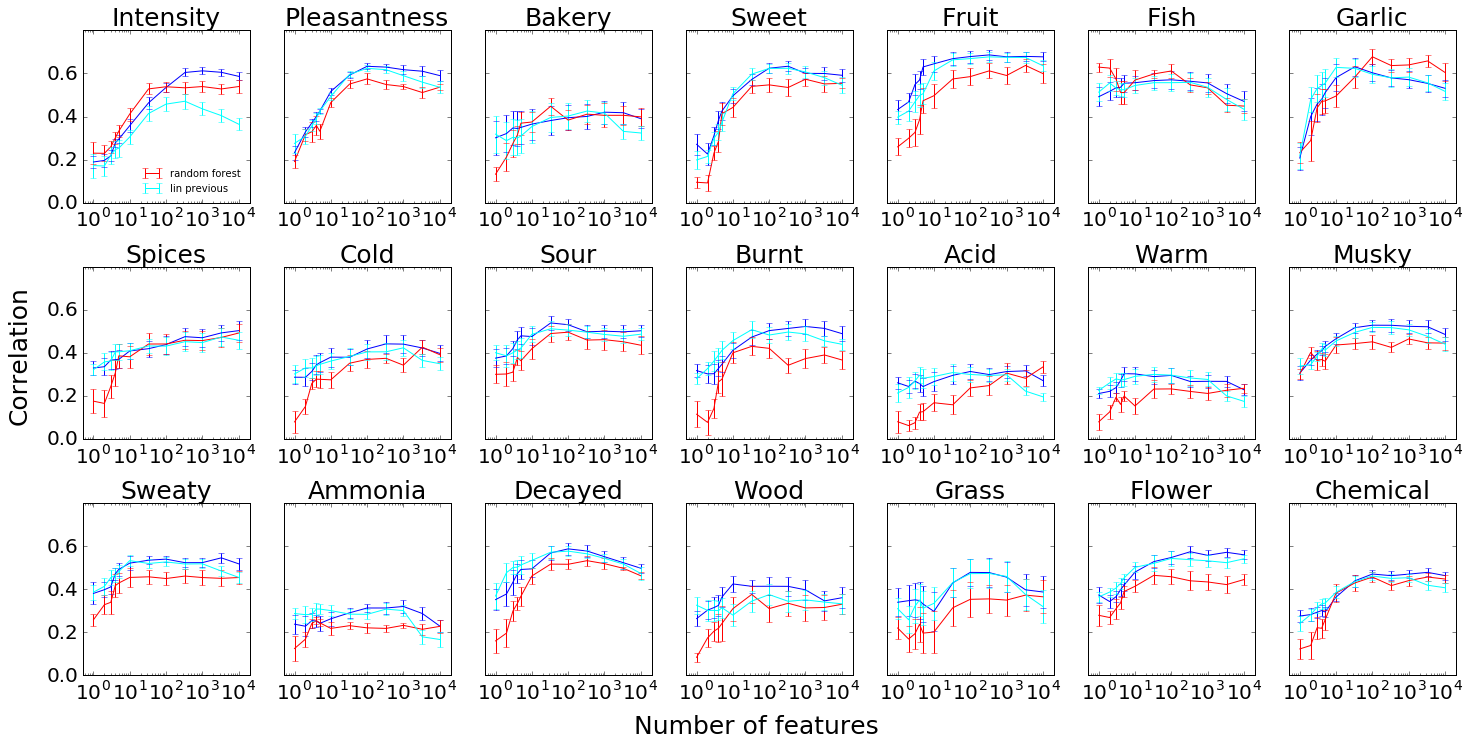

In [9]:
n_features = [1,2,3,4,5,10,33,100,333,1000,3333,10000]
#assert np.array_equal(np.array(n_features),np.array(linear_mean_noleak['number of features']))
fig,axes = plt.subplots(3,7,sharex=False,sharey=True,figsize=(20,10))
for col,ax in enumerate(axes.flat):
    lin_means = linear_mean_noleak[DESCRIPTORS[col]]
    RF_means = RF_mean_noleak[DESCRIPTORS[col]]
    previous_means = linear_mean_previous[DESCRIPTORS[col]]
    
    ax.errorbar(n_features,lin_means,linear_sem_noleak[DESCRIPTORS[col]],color='blue',label='linear')
    ax.errorbar(n_features,RF_means,RF_sem_noleak[DESCRIPTORS[col]],color='red',label='random forest')
    ax.errorbar(n_features,previous_means,linear_sem_previous[DESCRIPTORS[col]],color='cyan',label='lin previous')
    
    if col==0:
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        lg = ax.legend(handles[1:], labels[1:], loc=4, fontsize=10)
        lg.draw_frame(False)
    ax.set_xlim(0.5,20000)
    ax.set_ylim(0,0.8)
    ax.set_yticks(np.linspace(0,0.6,4))
    ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=20)
    ax.set_xticklabels(n_features,size=20)
    ax.set_xscale('log')
    descriptor = DESCRIPTORS[col].split('/')[1 if col==1 else 0]
    descriptor = descriptor[0]+descriptor[1:].lower()
    ax.set_title(descriptor, size=25)
plt.tight_layout()
fig.text(0.5, -0.025, 'Number of features', ha='center', size=25)
fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=25);